In [2]:
# CELL 1: Setup & Imports
"""
ROI Creation for Longitudinal Hemispherectomy Study
====================================================
Creates functional ROIs using Leave-One-Out approach in ses-01
Based on Liu et al. 2025 methodology

Author: Claire Simmons
Date: October 2025
"""

import numpy as np
import nibabel as nib
import pandas as pd
from scipy import ndimage
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
import os
warnings.filterwarnings('ignore')

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


In [3]:
# CELL 2: Configuration & Paths
"""
Define all paths, subjects, and ROI configuration
"""

# Base paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')

# Subject configuration
SUBJECTS = {
    'sub-004': {
        'patient_code': 'UD',
        'resection': 'Right posterior VOTC',
        'intact_hemisphere': 'left',
        'sessions': [1, 2, 3, 5, 6]
    },
    'sub-007': {
        'patient_code': 'OT', 
        'resection': 'Left anterior temporal',
        'intact_hemisphere': 'left',
        'sessions': [1, 3, 4]
    },
    'sub-021': {
        'patient_code': 'TC',
        'resection': 'Left posterior VOTC & parietal',
        'intact_hemisphere': 'right',
        'sessions': [1, 2, 3]
    }
}

# ROI Configuration - Maps to Julian parcels
ROI_CONFIG = {
    'FFA': {
        'cope': 6,
        'contrast': 'Face > All',
        'parcel_prefix': 'FFA'
    },
    'OFA': {
        'cope': 6,
        'contrast': 'Face > All',
        'parcel_prefix': 'OFA'
    },
    'PFS_faces': {
        'cope': 6,
        'contrast': 'Face > All',
        'parcel_prefix': 'PFS'
    },
    'PFS_objects': {
        'cope': 8,
        'contrast': 'Object > All',
        'parcel_prefix': 'PFS'
    },
    'LO': {
        'cope': 8,
        'contrast': 'Object > All',
        'parcel_prefix': 'LO'
    },
    'PPA': {
        'cope': 7,
        'contrast': 'House > All',
        'parcel_prefix': 'PPA'
    },
    'OPA': {
        'cope': 7,
        'contrast': 'House > All',
        'parcel_prefix': 'OPA'
    }
}

# Analysis parameters
HEMISPHERES = ['left', 'right']
SPHERE_RADII = [6, 8, 10]  # mm
Z_THRESHOLD = 0.5  # Z-score threshold for voxel selection
SESSION = 'ses-01'
N_RUNS = 3
PERCENTILE = 95  # Top 5% of voxels within parcel

print(f"Configuration loaded:")
print(f"  Subjects: {list(SUBJECTS.keys())}")
print(f"  ROIs: {list(ROI_CONFIG.keys())}")
print(f"  Hemispheres: {HEMISPHERES}")
print(f"  Sphere radii: {SPHERE_RADII} mm")
print(f"  Z threshold: {Z_THRESHOLD}")
print(f"  Top voxel percentile: {PERCENTILE}")

Configuration loaded:
  Subjects: ['sub-004', 'sub-007', 'sub-021']
  ROIs: ['FFA', 'OFA', 'PFS_faces', 'PFS_objects', 'LO', 'PPA', 'OPA']
  Hemispheres: ['left', 'right']
  Sphere radii: [6, 8, 10] mm
  Z threshold: 0.5
  Top voxel percentile: 95


In [6]:
# CELL 3: Visualize Anatomical Parcels
"""
Load and visualize registered Julian parcels
"""

def load_parcel(subject_id, parcel_name, hemisphere):
    """Load registered parcel mask"""
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    parcel_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'rois' / 'parcels' / \
                  f'{hemi_prefix}{parcel_name}.nii.gz'
    
    if not parcel_file.exists():
        return None
    
    img = nib.load(parcel_file)
    return img

# Check parcel coverage for each subject
print("Parcel Coverage Check:")
print("=" * 60)

for subject_id in SUBJECTS.keys():
    print(f"\n{subject_id}:")
    
    for roi_name, roi_config in ROI_CONFIG.items():
        parcel_name = roi_config['parcel_prefix']
        
        for hemisphere in HEMISPHERES:
            parcel_img = load_parcel(subject_id, parcel_name, hemisphere)
            
            if parcel_img is not None:
                data = parcel_img.get_fdata()
                n_voxels = int(np.sum(data > 0))
                hemi_label = 'L' if hemisphere == 'left' else 'R'
                print(f"  {hemi_label}-{roi_name}: {n_voxels} voxels")
            else:
                hemi_label = 'L' if hemisphere == 'left' else 'R'
                print(f"  {hemi_label}-{roi_name}: NOT FOUND")

print("\n" + "=" * 60)
print("Parcels loaded successfully!")

Parcel Coverage Check:

sub-004:
  L-FFA: 1444 voxels
  R-FFA: 4734 voxels
  L-OFA: 1137 voxels
  R-OFA: 4007 voxels
  L-PFS_faces: 9145 voxels
  R-PFS_faces: 6478 voxels
  L-PFS_objects: 9145 voxels
  R-PFS_objects: 6478 voxels
  L-LO: 31862 voxels
  R-LO: 27754 voxels
  L-PPA: 6583 voxels
  R-PPA: 5987 voxels
  L-OPA: 1793 voxels
  R-OPA: NOT FOUND

sub-007:
  L-FFA: 1612 voxels
  R-FFA: 5742 voxels
  L-OFA: 1273 voxels
  R-OFA: 4507 voxels
  L-PFS_faces: 10591 voxels
  R-PFS_faces: 7533 voxels
  L-PFS_objects: 10591 voxels
  R-PFS_objects: 7533 voxels
  L-LO: 36088 voxels
  R-LO: 33424 voxels
  L-PPA: 7585 voxels
  R-PPA: 6726 voxels
  L-OPA: 1992 voxels
  R-OPA: NOT FOUND

sub-021:
  L-FFA: 903 voxels
  R-FFA: 2935 voxels
  L-OFA: 696 voxels
  R-OFA: 2563 voxels
  L-PFS_faces: 5993 voxels
  R-PFS_faces: 4105 voxels
  L-PFS_objects: 5993 voxels
  R-PFS_objects: 4105 voxels
  L-LO: 20503 voxels
  R-LO: 18280 voxels
  L-PPA: 4276 voxels
  R-PPA: 3827 voxels
  L-OPA: 1100 voxels
  R-OP

In [ ]:
# CELL 4: Helper Functions - LOO Peak Finding
"""
Functions for Leave-One-Out peak finding within anatomical parcels
"""

def find_peak_in_parcel(zstat_img, parcel_mask, threshold=Z_THRESHOLD, percentile=PERCENTILE):
    """
    Find peak voxel within parcel using percentile thresholding
    
    Parameters:
    -----------
    zstat_img : nibabel image
        Z-statistic map
    parcel_mask : nibabel image
        Binary parcel mask
    threshold : float
        Minimum z-score
    percentile : float
        Percentile for top voxels (95 = top 5%)
    
    Returns:
    --------
    peak_info : dict or None
    """
    zstat_data = zstat_img.get_fdata()
    mask_data = parcel_mask.get_fdata()
    affine = zstat_img.affine
    
    # Apply parcel mask
    masked_zstat = np.where(mask_data > 0, zstat_data, 0)
    
    # Threshold
    thresholded = masked_zstat > threshold
    
    if not np.any(thresholded):
        return None
    
    # Get values within mask
    masked_values = masked_zstat[thresholded]
    
    if len(masked_values) == 0:
        return None
    
    # Percentile threshold
    perc_threshold = np.percentile(masked_values, percentile)
    
    # Find peak above percentile
    top_voxels = masked_zstat >= perc_threshold
    
    if not np.any(top_voxels):
        return None
    
    # Get peak voxel
    peak_voxel = np.unravel_index(np.argmax(masked_zstat), masked_zstat.shape)
    peak_world = nib.affines.apply_affine(affine, peak_voxel)
    
    return {
        'x': float(peak_world[0]),
        'y': float(peak_world[1]),
        'z': float(peak_world[2]),
        'peak_z': float(zstat_data[peak_voxel]),
        'n_above_threshold': int(np.sum(thresholded)),
        'voxel_coords': peak_voxel
    }

def create_sphere_roi(center_coords, radius_mm, reference_img):
    """
    Create spherical ROI mask
    
    Parameters:
    -----------
    center_coords : dict
        {'x': x, 'y': y, 'z': z} in world coordinates
    radius_mm : float
        Radius in mm
    reference_img : nibabel image
        Reference image for dimensions
    
    Returns:
    --------
    roi_img : nibabel image
    """
    data = reference_img.get_fdata()
    affine = reference_img.affine
    
    # Create coordinate grid
    i, j, k = np.mgrid[0:data.shape[0], 0:data.shape[1], 0:data.shape[2]]
    coords = np.vstack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
    
    # Transform to world
    world_coords = affine.dot(coords)[:3, :].T
    
    # Center
    center = np.array([center_coords['x'], center_coords['y'], center_coords['z']])
    
    # Calculate distances
    distances = np.sqrt(np.sum((world_coords - center)**2, axis=1))
    
    # Create mask
    mask = (distances <= radius_mm).reshape(data.shape)
    
    return nib.Nifti1Image(mask.astype(np.float32), affine, reference_img.header)

def calculate_peak_stability(peaks):
    """
    Calculate variability of LOO peaks
    
    Returns:
    --------
    mean_coords : np.array
    std_distance : float (mm)
    """
    coords = np.array([[p['x'], p['y'], p['z']] for p in peaks])
    mean_coords = np.mean(coords, axis=0)
    
    distances = np.sqrt(np.sum((coords - mean_coords)**2, axis=1))
    std_distance = np.std(distances)
    
    return mean_coords, std_distance

print("Helper functions loaded!")

Helper functions loaded!


In [8]:
# CELL 5: Run Leave-One-Out Peak Finding
"""
For each ROI, find peaks using LOO cross-validation
Select most stable peak (closest to mean)
"""

all_peaks = {}

for subject_id in SUBJECTS.keys():
    print(f"\n{'='*60}")
    print(f"Processing {subject_id} ({SUBJECTS[subject_id]['patient_code']})")
    print(f"{'='*60}")
    
    all_peaks[subject_id] = {}
    
    # Load reference image
    ref_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'fsl' / 'loc' / \
               'run-01' / '1stLevel.feat' / 'reg_standard' / 'stats' / 'zstat1.nii.gz'
    reference_img = nib.load(ref_file)
    
    for roi_name, roi_config in ROI_CONFIG.items():
        print(f"\n{roi_name} ({roi_config['contrast']}):")
        
        all_peaks[subject_id][roi_name] = {}
        cope_num = roi_config['cope']
        parcel_prefix = roi_config['parcel_prefix']
        
        for hemisphere in HEMISPHERES:
            hemi_label = 'L' if hemisphere == 'left' else 'R'
            print(f"  {hemi_label}-{roi_name}:", end=" ")
            
            # Load parcel
            parcel_img = load_parcel(subject_id, parcel_prefix, hemisphere)
            if parcel_img is None:
                print("Parcel not found")
                all_peaks[subject_id][roi_name][hemisphere] = None
                continue
            
            # Load zstats for all runs
            run_zstats = []
            for run in range(1, N_RUNS + 1):
                zstat_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'fsl' / 'loc' / \
                            f'run-0{run}' / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope_num}.nii.gz'
                
                if not zstat_file.exists():
                    print(f"Missing run-0{run}")
                    break
                
                run_zstats.append(nib.load(zstat_file))
            
            if len(run_zstats) < N_RUNS:
                print(f"Incomplete runs ({len(run_zstats)}/{N_RUNS})")
                all_peaks[subject_id][roi_name][hemisphere] = None
                continue
            
            # Leave-one-out loop
            loo_peaks = []
            
            for left_out_idx in range(N_RUNS):
                # Average remaining runs
                training_indices = [i for i in range(N_RUNS) if i != left_out_idx]
                training_data = np.mean([run_zstats[i].get_fdata() for i in training_indices], axis=0)
                training_img = nib.Nifti1Image(training_data, run_zstats[0].affine, run_zstats[0].header)
                
                # Find peak (percentile-based, from Cell 4)
                peak = find_peak_in_parcel(training_img, parcel_img)
                
                if peak is not None:
                    loo_peaks.append(peak)
                    
                # Add to Cell 5 when peak is None
                if peak is None:
                    # Debug: check what's in the parcel
                    training_data = np.mean([run_zstats[i].get_fdata() for i in [0,1]], axis=0)
                    parcel_data = parcel_img.get_fdata()
                    masked = training_data * (parcel_data > 0)
                    
                    print(f"max_z={np.max(masked):.2f}, min_z={np.min(masked):.2f}, "
                        f"n_positive={np.sum(masked > 0)}, n_above_2.3={np.sum(masked > 2.3)}")    
            
            if len(loo_peaks) == 0:
                print("No peaks found")
                all_peaks[subject_id][roi_name][hemisphere] = None
                continue
            
            # Select most stable peak (closest to LOO mean)
            mean_coords, std_dist = calculate_peak_stability(loo_peaks)
            
            distances_to_mean = []
            for peak in loo_peaks:
                peak_coords = np.array([peak['x'], peak['y'], peak['z']])
                dist = np.sqrt(np.sum((peak_coords - mean_coords)**2))
                distances_to_mean.append(dist)
            
            best_idx = np.argmin(distances_to_mean)
            best_peak = loo_peaks[best_idx]
            
            best_peak['loo_variability_mm'] = float(std_dist)
            best_peak['n_loo_peaks'] = len(loo_peaks)
            
            all_peaks[subject_id][roi_name][hemisphere] = best_peak
            
            print(f"Peak at ({best_peak['x']:.1f}, {best_peak['y']:.1f}, {best_peak['z']:.1f}), "
                  f"z={best_peak['peak_z']:.2f}, variability={std_dist:.2f}mm")

# Check what we got
for subject_id in SUBJECTS.keys():
    for roi_name in ROI_CONFIG.keys():
        for hemi in HEMISPHERES:
            peak = all_peaks[subject_id][roi_name].get(hemi)
            if peak is not None:
                print(f"{subject_id} {hemi[0]}-{roi_name}: Found")


print(f"\n{'='*60}")
print("LOO peak finding complete!")
print(f"{'='*60}")


Processing sub-004 (UD)

FFA (Face > All):
  L-FFA: Peak at (-34.5, -50.0, -3.0), z=0.69, variability=0.57mm
  R-FFA: Peak at (47.5, -37.0, -7.0), z=1.91, variability=0.71mm

OFA (Face > All):
  L-OFA: max_z=1.12, min_z=-2.19, n_positive=561, n_above_2.3=0
Peak at (-33.5, -76.0, 5.0), z=1.37, variability=0.00mm
  R-OFA: Peak at (48.5, -66.0, 1.0), z=2.21, variability=2.89mm

PFS_faces (Face > All):
  L-PFS_faces: Peak at (-32.5, -37.0, -6.0), z=1.94, variability=2.00mm
  R-PFS_faces: Peak at (47.5, -37.0, -8.0), z=2.01, variability=1.23mm

PFS_objects (Object > All):
  L-PFS_objects: Peak at (-29.5, -45.0, -7.0), z=4.06, variability=1.76mm
  R-PFS_objects: Peak at (45.5, -35.0, -1.0), z=2.53, variability=3.57mm

LO (Object > All):
  L-LO: Peak at (-26.5, -82.0, 20.0), z=4.67, variability=3.45mm
  R-LO: Peak at (53.5, -63.0, -1.0), z=3.27, variability=0.94mm

PPA (House > All):
  L-PPA: Peak at (-22.5, -42.0, 10.0), z=2.67, variability=0.30mm
  R-PPA: Peak at (37.5, -28.0, 7.0), z=1.36

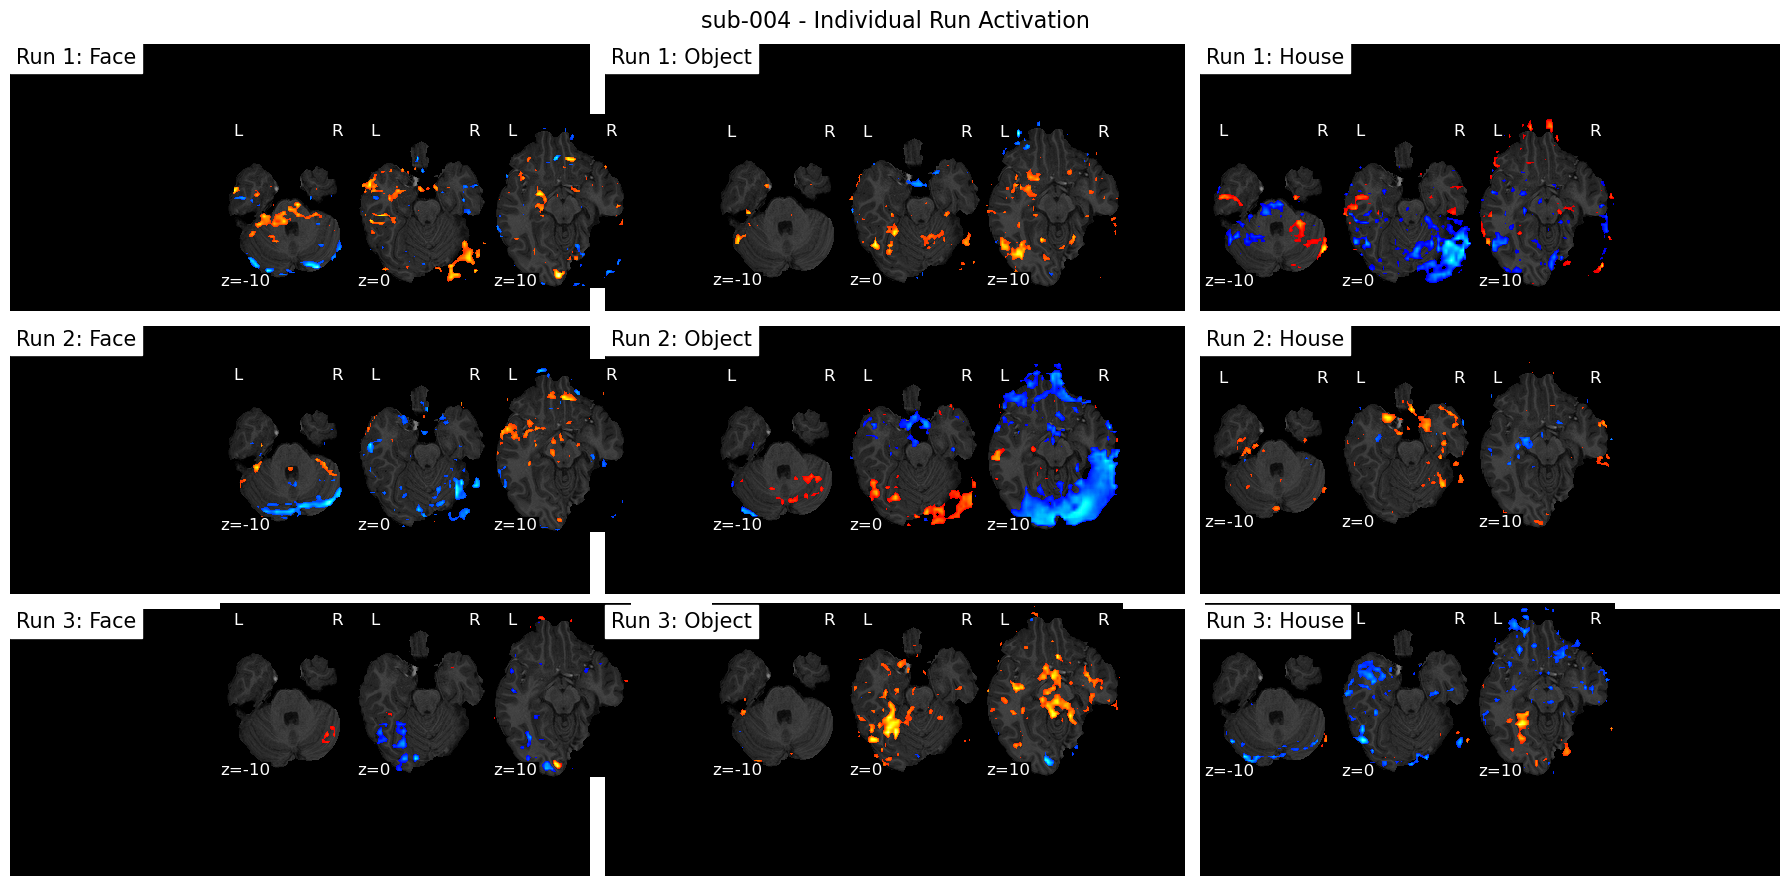

In [9]:
# Check raw functional activation
import matplotlib.pyplot as plt
from nilearn import plotting

subject_id = 'sub-004'
anat_file = BASE_DIR / subject_id / SESSION / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'

fig, axes = plt.subplots(3, 3, figsize=(18, 9))
fig.suptitle(f'{subject_id} - Individual Run Activation', fontsize=16)

for run_idx in range(3):
    for cope_idx, (cope_num, cope_name) in enumerate([(6, 'Face'), (8, 'Object'), (7, 'House')]):
        zstat_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'fsl' / 'loc' / \
                     f'run-0{run_idx+1}' / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope_num}.nii.gz'
        
        ax = axes[run_idx, cope_idx]
        plotting.plot_stat_map(
            zstat_file, bg_img=anat_file, threshold=2.3,
            display_mode='z', cut_coords=[-10, 0, 10],
            axes=ax, title=f'Run {run_idx+1}: {cope_name}', colorbar=False
        )

plt.tight_layout()
plt.show()

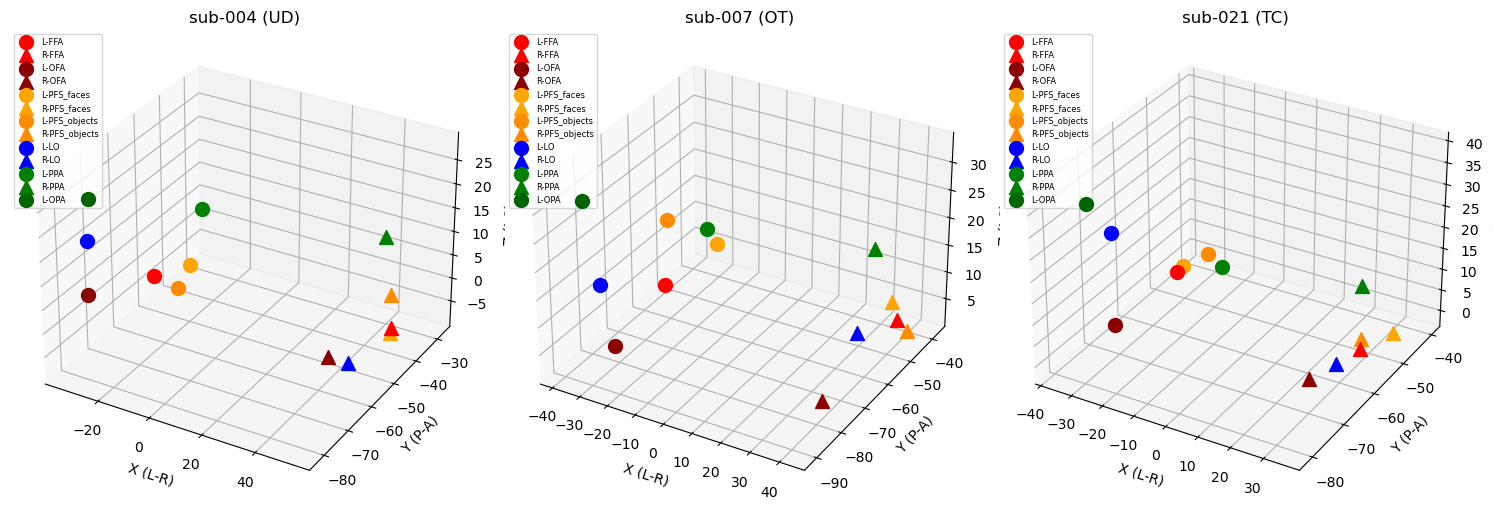

Visualization saved!


In [10]:
# CELL 6: Visualize Peak Locations
"""
3D visualization of peak locations
"""

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))

roi_colors = {
    'FFA': 'red',
    'OFA': 'darkred',
    'PFS_faces': 'orange',
    'PFS_objects': 'darkorange',
    'LO': 'blue',
    'PPA': 'green',
    'OPA': 'darkgreen'
}

hemi_markers = {'left': 'o', 'right': '^'}

for idx, (subject_id, subject_info) in enumerate(SUBJECTS.items(), 1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    
    for roi_name in ROI_CONFIG.keys():
        for hemisphere in HEMISPHERES:
            peak = all_peaks[subject_id][roi_name].get(hemisphere)
            
            if peak is not None:
                ax.scatter(peak['x'], peak['y'], peak['z'],
                          c=roi_colors[roi_name],
                          marker=hemi_markers[hemisphere],
                          s=100,
                          label=f"{hemisphere[0].upper()}-{roi_name}")
    
    ax.set_xlabel('X (L-R)')
    ax.set_ylabel('Y (P-A)')
    ax.set_zlabel('Z (I-S)')
    ax.set_title(f"{subject_id} ({subject_info['patient_code']})")
    
    # Legend (remove duplicates)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=6, loc='upper left')

plt.tight_layout()
plt.savefig(BASE_DIR / 'roi_peaks_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved!")

In [11]:
# CELL 7: Create Sphere ROIs and Save
"""
Create spherical ROI masks at multiple radii
Save peak coordinates and quality metrics
"""

summary_rows = []

for subject_id in SUBJECTS.keys():
    print(f"\nCreating spheres for {subject_id}...")
    
    # Output directory
    roi_dir = BASE_DIR / subject_id / SESSION / 'derivatives' / 'rois' / 'functional_peaks'
    roi_dir.mkdir(parents=True, exist_ok=True)
    
    # Reference image
    ref_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'fsl' / 'loc' / \
           'run-01' / '1stLevel.feat' / 'reg_standard' / 'stats' / 'zstat1.nii.gz'
    reference_img = nib.load(ref_file)
    
    for roi_name in ROI_CONFIG.keys():
        for hemisphere in HEMISPHERES:
            peak = all_peaks[subject_id][roi_name].get(hemisphere)
            
            if peak is None:
                continue
            
            hemi_label = 'l' if hemisphere == 'left' else 'r'
            
            # Create spheres at each radius
            voxel_counts = {}
            for radius in SPHERE_RADII:
                sphere = create_sphere_roi(peak, radius, reference_img)
                
                # Save
                output_file = roi_dir / f'{hemi_label}_{roi_name}_r{radius}mm.nii.gz'
                nib.save(sphere, output_file)
                
                # Count voxels
                n_voxels = int(np.sum(sphere.get_fdata() > 0))
                voxel_counts[f'n_voxels_r{radius}mm'] = n_voxels
            
            print(f"  {hemi_label}_{roi_name}: {voxel_counts}")
            
            # Add to summary
            row = {
                'subject': subject_id,
                'patient_code': SUBJECTS[subject_id]['patient_code'],
                'roi_name': f"{hemi_label}_{roi_name}",
                'roi_base': roi_name,
                'hemisphere': hemisphere,
                'x': peak['x'],
                'y': peak['y'],
                'z': peak['z'],
                'peak_z': peak['peak_z'],
                'n_above_threshold': peak['n_above_threshold'],
                'loo_variability_mm': peak.get('loo_variability_mm', np.nan),
                'n_loo_peaks': peak.get('n_loo_peaks', 0),
                **voxel_counts
            }
            summary_rows.append(row)

# Create summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Save
output_file = BASE_DIR / 'roi_peaks_summary.csv'
summary_df.to_csv(output_file, index=False)
print(f"\nSaved summary: {output_file}")

# Save per-subject
for subject_id in SUBJECTS.keys():
    subject_df = summary_df[summary_df['subject'] == subject_id]
    subject_file = BASE_DIR / subject_id / SESSION / 'derivatives' / 'rois' / \
                   'functional_peaks' / 'roi_peaks.csv'
    subject_df.to_csv(subject_file, index=False)

print("\n" + "="*60)
print("ROI CREATION COMPLETE")
print("="*60)
display(summary_df)

# Quality check
print("\nQuality Metrics:")
print(f"  Mean LOO variability: {summary_df['loo_variability_mm'].mean():.2f} mm")
print(f"  Max LOO variability: {summary_df['loo_variability_mm'].max():.2f} mm")
print(f"  ROIs with variability >10mm: {(summary_df['loo_variability_mm'] > 10).sum()}")
print(f"\nTotal ROIs created: {len(summary_df)}")
for subject_id in SUBJECTS.keys():
    n_rois = len(summary_df[summary_df['subject'] == subject_id])
    print(f"  {subject_id}: {n_rois} ROIs")


Creating spheres for sub-004...


  l_FFA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_FFA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_OFA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_OFA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_PFS_faces: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_PFS_faces: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_PFS_objects: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_PFS_objects: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_LO: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_LO: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_PPA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  r_PPA: {'n_voxels_r6mm': 925, 'n_voxels_r8mm': 2109, 'n_voxels_r10mm': 4169}
  l_OPA: {'n_voxels_r6mm':

,subject,patient_code,roi_name,roi_base,hemisphere,x,y,z,peak_z,n_above_threshold,loo_variability_mm,n_loo_peaks,n_voxels_r6mm,n_voxels_r8mm,n_voxels_r10mm
0,sub-004,UD,l_FFA,FFA,left,-34.5,-50.0,-3.0,0.687570,7,0.566558,3,925,2109,4169
1,sub-004,UD,r_FFA,FFA,right,47.5,-37.0,-7.0,1.907803,280,0.706805,3,925,2109,4169
2,sub-004,UD,l_OFA,OFA,left,-33.5,-76.0,5.0,1.366436,119,0.000000,2,925,2109,4169
3,sub-004,UD,r_OFA,OFA,right,48.5,-66.0,1.0,2.208637,1308,2.891229,3,925,2109,4169
4,sub-004,UD,l_PFS_faces,PFS_faces,left,-32.5,-37.0,-6.0,1.938427,1035,2.003151,3,925,2109,4169
5,sub-004,UD,r_PFS_faces,PFS_faces,right,47.5,-37.0,-8.0,2.013146,617,1.232341,3,925,2109,4169
6,sub-004,UD,l_PFS_objects,PFS_objects,left,-29.5,-45.0,-7.0,4.059860,6788,1.759884,3,925,2109,4169
7,sub-004,UD,r_PFS_objects,PFS_objects,right,45.5,-35.0,-1.0,2.530296,2137,3.565014,3,925,2109,4169
8,sub-004,UD,l_LO,LO,left,-26.5,-82.0,20.0,4.667789,20790,3.452991,3,925,2109,4169
9,sub-004,UD,r_LO,LO,right,53.5,-63.0,-1.0,3.274807,6288,0.936589,3,925,2109,4169



Quality Metrics:
  Mean LOO variability: 1.11 mm
  Max LOO variability: 3.57 mm
  ROIs with variability >10mm: 0

Total ROIs created: 39
  sub-004: 13 ROIs
  sub-007: 13 ROIs
  sub-021: 13 ROIs


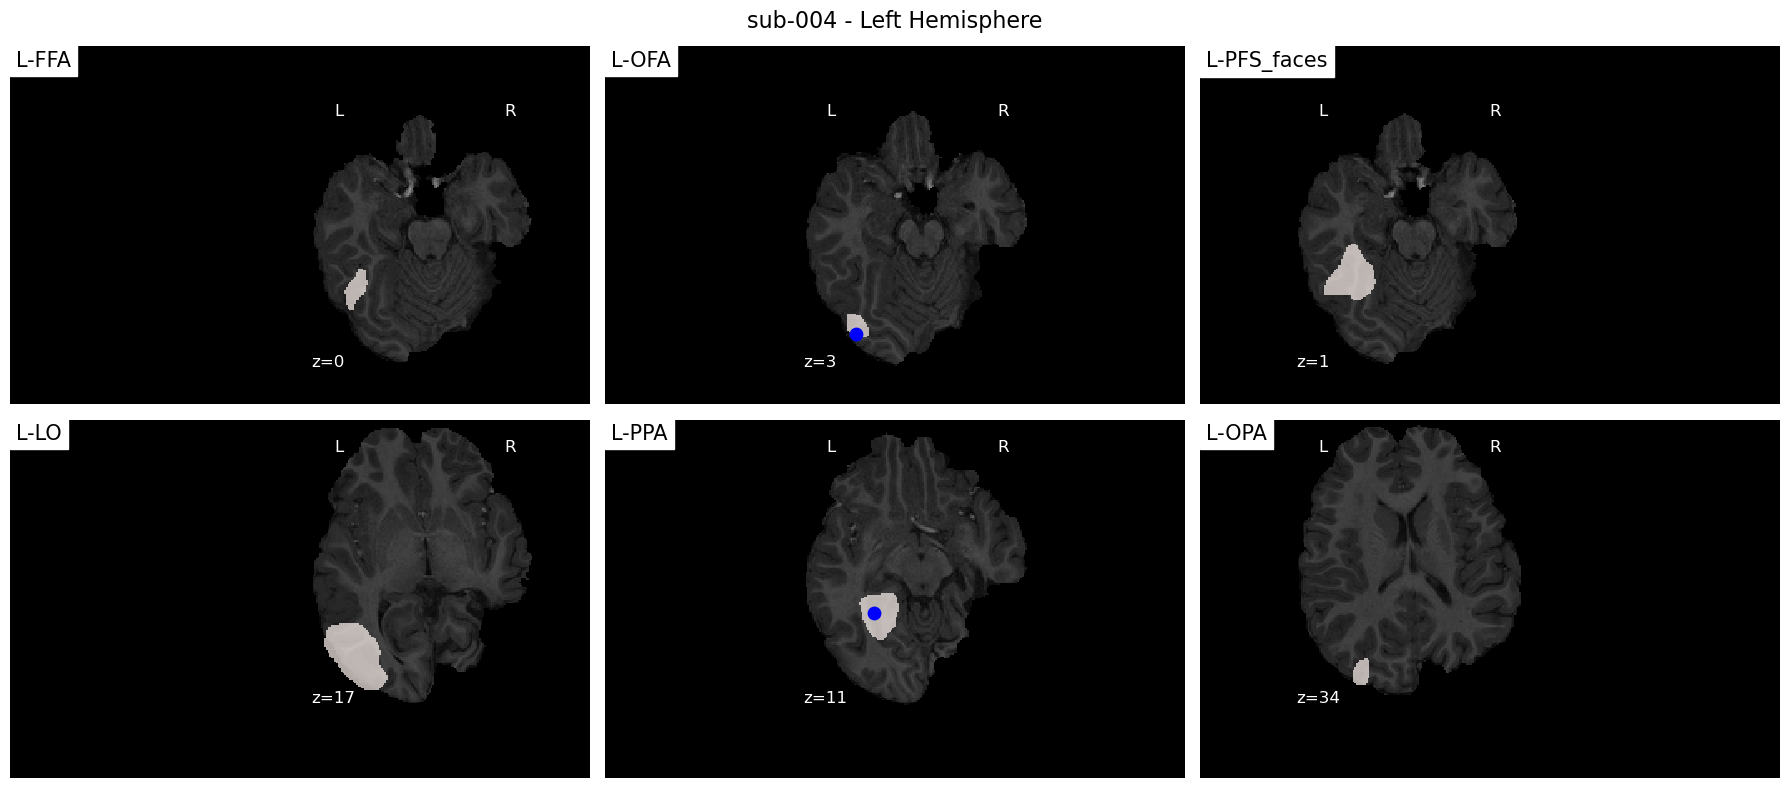

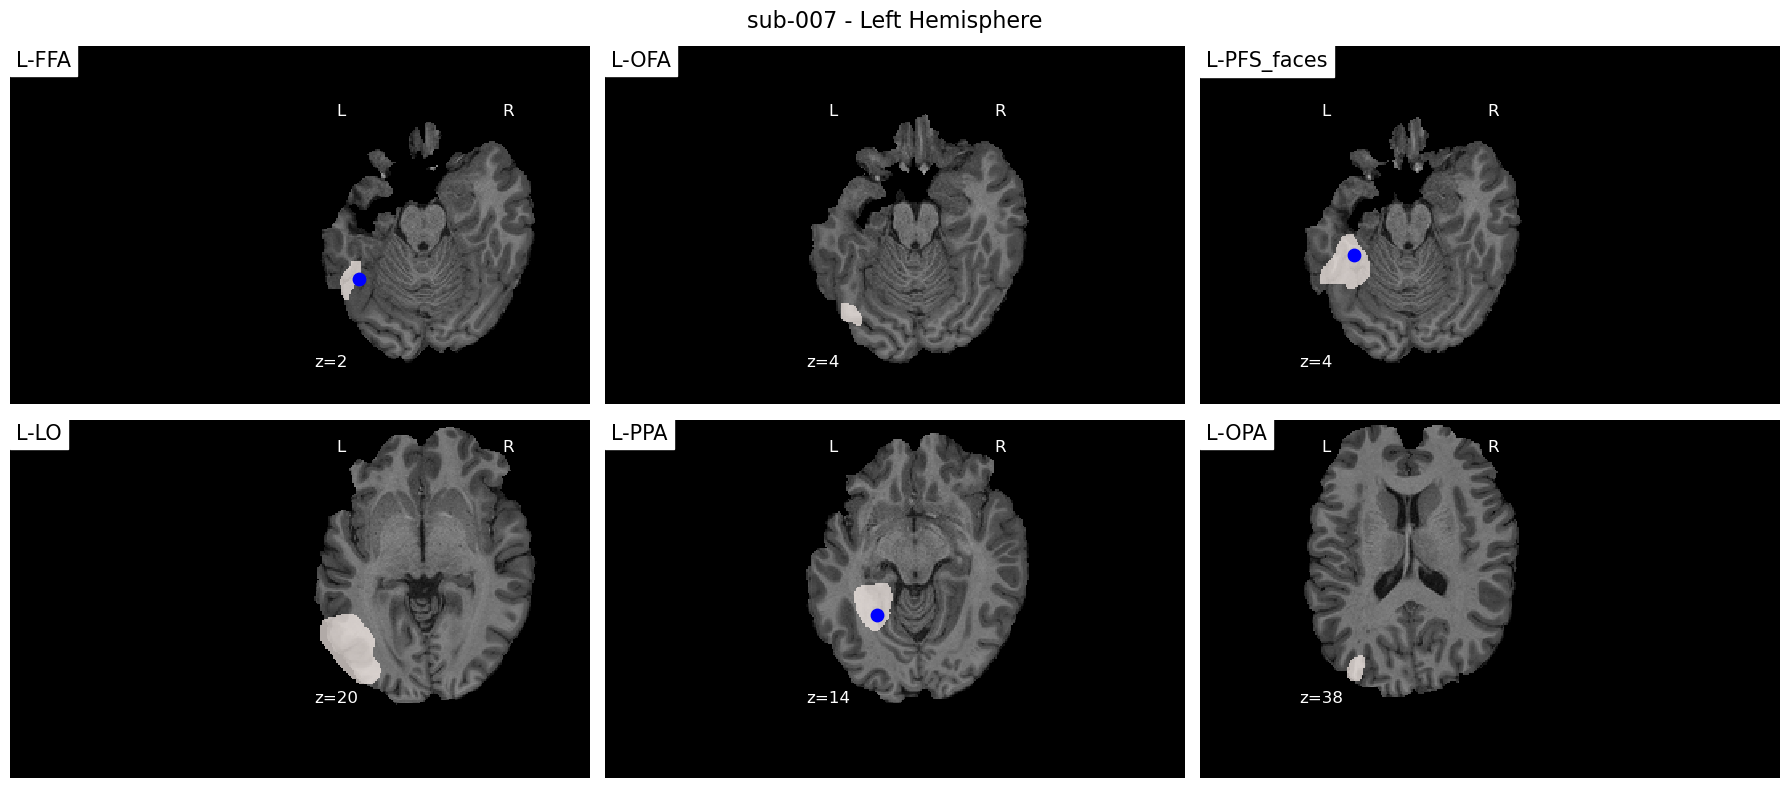

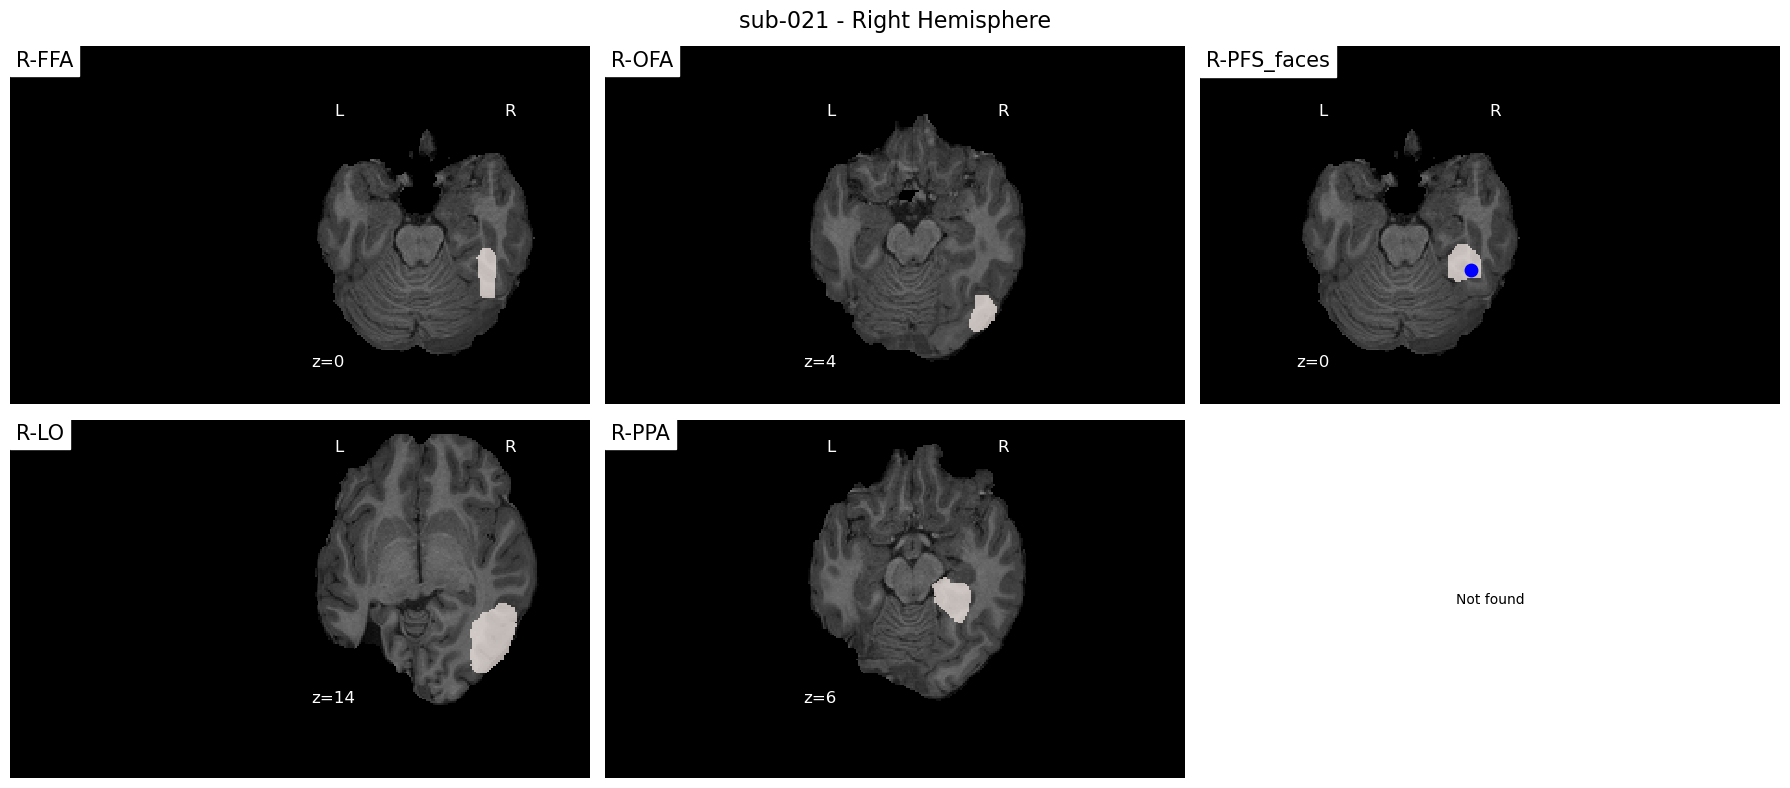

Red = parcel, Blue = peak location


In [12]:
# CELL 8: Visualize ROI Parcels with Peaks
from nilearn import plotting

for subject_id in SUBJECTS.keys():
    intact_hemi = SUBJECTS[subject_id]['intact_hemisphere']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle(f"{subject_id} - {intact_hemi.capitalize()} Hemisphere", fontsize=16)
    
    anat_file = BASE_DIR / subject_id / SESSION / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    
    roi_list = ['FFA', 'OFA', 'PFS_faces', 'LO', 'PPA', 'OPA']
    
    for idx, roi_name in enumerate(roi_list):
        ax = axes.flatten()[idx]
        
        parcel_prefix = ROI_CONFIG[roi_name]['parcel_prefix']
        parcel_img = load_parcel(subject_id, parcel_prefix, intact_hemi)
        
        if parcel_img is not None:
            data = parcel_img.get_fdata()
            coords = np.where(data > 0)
            center_vox = [np.mean(c) for c in coords]
            center_world = nib.affines.apply_affine(parcel_img.affine, center_vox)
            z_coord = center_world[2]
            
            display = plotting.plot_roi(
                parcel_img, bg_img=anat_file,
                display_mode='z', cut_coords=[z_coord],
                axes=ax, title=f"{intact_hemi[0].upper()}-{roi_name}",
                colorbar=False, cmap='Reds', alpha=0.7
            )
            
            # Add peak marker
            peak = all_peaks[subject_id][roi_name].get(intact_hemi)
            if peak:
                display.add_markers(
                    [(peak['x'], peak['y'], peak['z'])],
                    marker_color='blue', marker_size=80
                )
        else:
            ax.text(0.5, 0.5, 'Not found', ha='center', va='center')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(BASE_DIR / f'{subject_id}_parcels_with_peaks.png', dpi=150)
    plt.show()

print("Red = parcel, Blue = peak location")

In [13]:
# CELL 9: Check LOO Peak Variability
"""
Display individual LOO peak coordinates and variability
"""

for subject_id in SUBJECTS.keys():
    intact_hemi = SUBJECTS[subject_id]['intact_hemisphere']
    print(f"\n{'='*60}")
    print(f"{subject_id} - {intact_hemi.capitalize()} Hemisphere")
    print(f"{'='*60}")
    
    for roi_name in ROI_CONFIG.keys():
        peak = all_peaks[subject_id][roi_name].get(intact_hemi)
        
        if peak is None:
            continue
        
        print(f"\n{roi_name}:")
        print(f"  Selected peak: ({peak['x']:.1f}, {peak['y']:.1f}, {peak['z']:.1f})")
        print(f"  Peak Z-score: {peak['peak_z']:.2f}")
        print(f"  LOO variability: {peak['loo_variability_mm']:.2f} mm")
        print(f"  Number of LOO peaks: {peak['n_loo_peaks']}")
        
        # Indicate stability
        if peak['loo_variability_mm'] < 5:
            print(f"  Status: ✓ Stable")
        elif peak['loo_variability_mm'] < 10:
            print(f"  Status: ⚠ Moderate variability")
        else:
            print(f"  Status: ✗ High variability")


sub-004 - Left Hemisphere

FFA:
  Selected peak: (-34.5, -50.0, -3.0)
  Peak Z-score: 0.69
  LOO variability: 0.57 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

OFA:
  Selected peak: (-33.5, -76.0, 5.0)
  Peak Z-score: 1.37
  LOO variability: 0.00 mm
  Number of LOO peaks: 2
  Status: ✓ Stable

PFS_faces:
  Selected peak: (-32.5, -37.0, -6.0)
  Peak Z-score: 1.94
  LOO variability: 2.00 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

PFS_objects:
  Selected peak: (-29.5, -45.0, -7.0)
  Peak Z-score: 4.06
  LOO variability: 1.76 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

LO:
  Selected peak: (-26.5, -82.0, 20.0)
  Peak Z-score: 4.67
  LOO variability: 3.45 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

PPA:
  Selected peak: (-22.5, -42.0, 10.0)
  Peak Z-score: 2.67
  LOO variability: 0.30 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

OPA:
  Selected peak: (-26.5, -81.0, 28.0)
  Peak Z-score: 1.74
  LOO variability: 0.31 mm
  Number of LOO peaks: 3
  Status: ✓ Stable

sub-007 

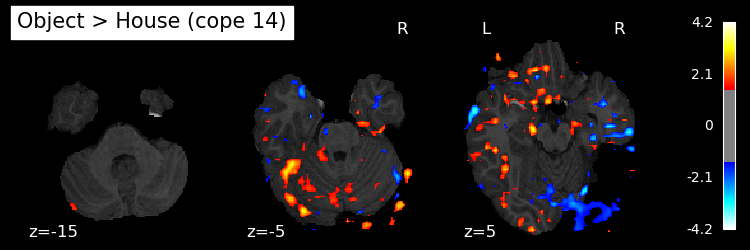

In [14]:
# Visualize cope 14 (Object>House)
subject_id = 'sub-004'
zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
             'run-01' / '1stLevel.feat' / 'reg_standard' / 'stats' / 'zstat14.nii.gz'
anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'

plotting.plot_stat_map(zstat_file, bg_img=anat_file, threshold=1.5,
                       display_mode='z', cut_coords=[-15, -5, 5],
                       title='Object > House (cope 14)')

In [16]:
# CELL: Find functional ROIs using cope 14 (Object>House)
from scipy import ndimage

def find_functional_roi(subject_id, cope_num, hemisphere, threshold=2.0):
    """Find ROI using functional activation within anatomical constraint"""
    
    # Combine all ventral parcels
    ventral_parcels = ['FFA', 'OFA', 'PFS', 'LO', 'PPA', 'OPA']
    combined_mask = np.zeros((176, 256, 256))
    
    for parcel in ventral_parcels:
        parcel_img = load_parcel(subject_id, parcel, hemisphere)
        if parcel_img:
            combined_mask += parcel_img.get_fdata()
    
    combined_mask = (combined_mask > 0).astype(int)
    
    # Load and average zstats
    zstats = []
    for run in range(1, 4):
        zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                     f'run-0{run}' / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope_num}.nii.gz'
        zstats.append(nib.load(zstat_file).get_fdata())
    
    mean_zstat = np.mean(zstats, axis=0)
    
    # Threshold and find largest cluster
    thresholded = (mean_zstat > threshold) * combined_mask
    labeled, n_clusters = ndimage.label(thresholded)
    
    if n_clusters == 0:
        return None, None, 0
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
    largest_cluster = np.argmax(cluster_sizes) + 1
    roi_mask = (labeled == largest_cluster)
    
    return roi_mask, mean_zstat, int(cluster_sizes[largest_cluster-1])

# Run for each subject
for subject_id in SUBJECTS.keys():
    intact_hemi = SUBJECTS[subject_id]['intact_hemisphere']
    print(f"\n{subject_id} ({intact_hemi} hemisphere):")
    
    roi_mask, mean_zstat, n_voxels = find_functional_roi(subject_id, 14, intact_hemi, threshold=2.0)
    
    if roi_mask is not None:
        print(f"  Found ROI: {n_voxels} voxels")
        # Find peak in ROI
        roi_zstat = mean_zstat * roi_mask
        peak_idx = np.unravel_index(np.argmax(roi_zstat), roi_zstat.shape)
        print(f"  Peak z-score: {mean_zstat[peak_idx]:.2f}")
    else:
        print(f"  No activation found")


sub-004 (left hemisphere):
  Found ROI: 612 voxels
  Peak z-score: 2.75

sub-007 (left hemisphere):
  Found ROI: 2945 voxels
  Peak z-score: 6.02

sub-021 (right hemisphere):
  Found ROI: 55 voxels
  Peak z-score: 2.37


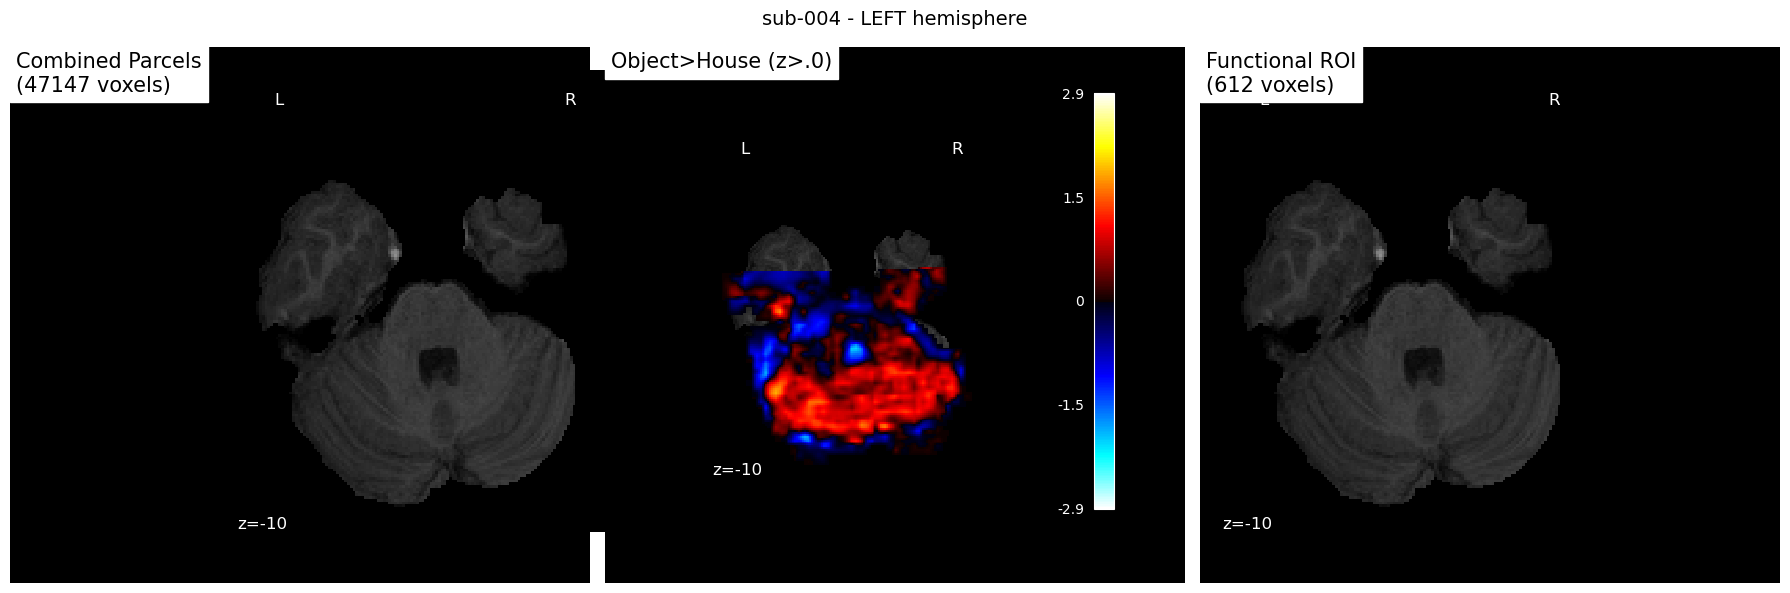

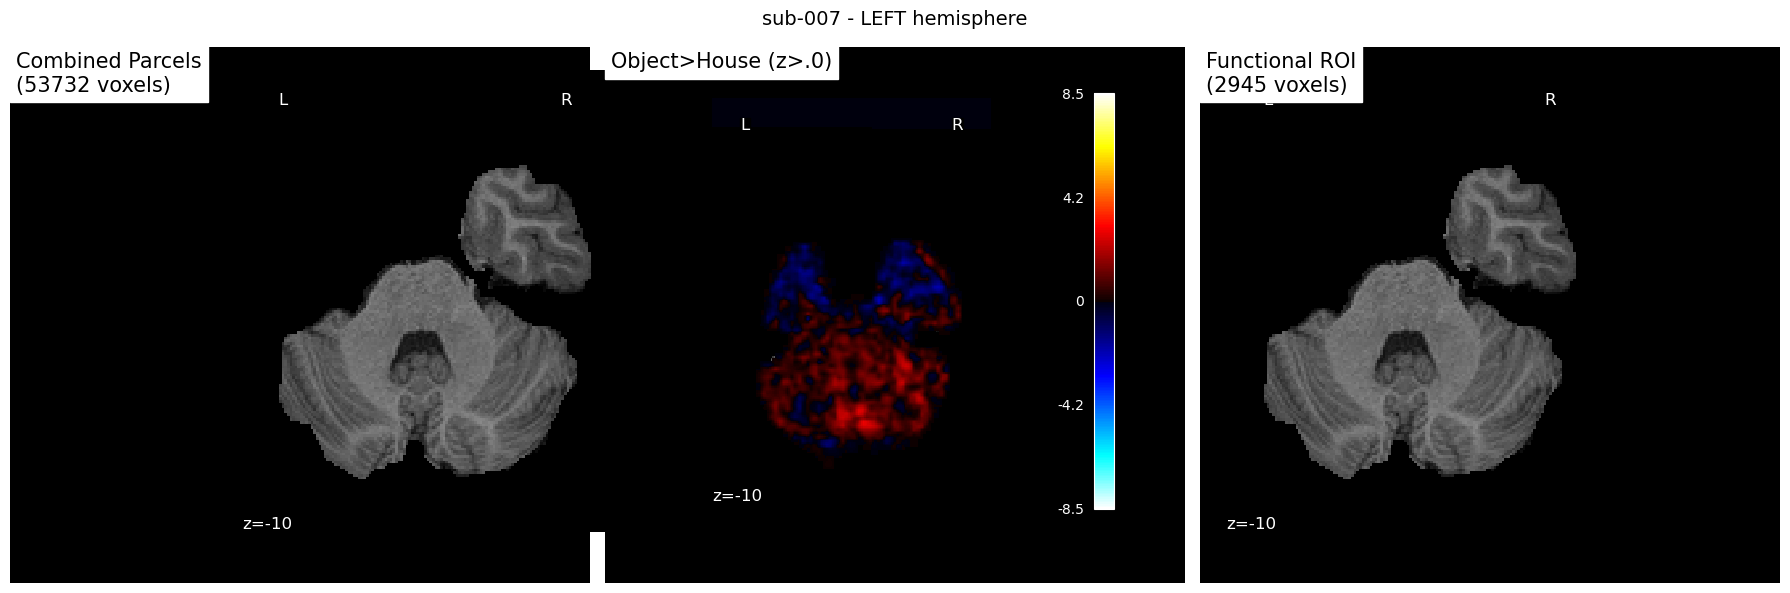

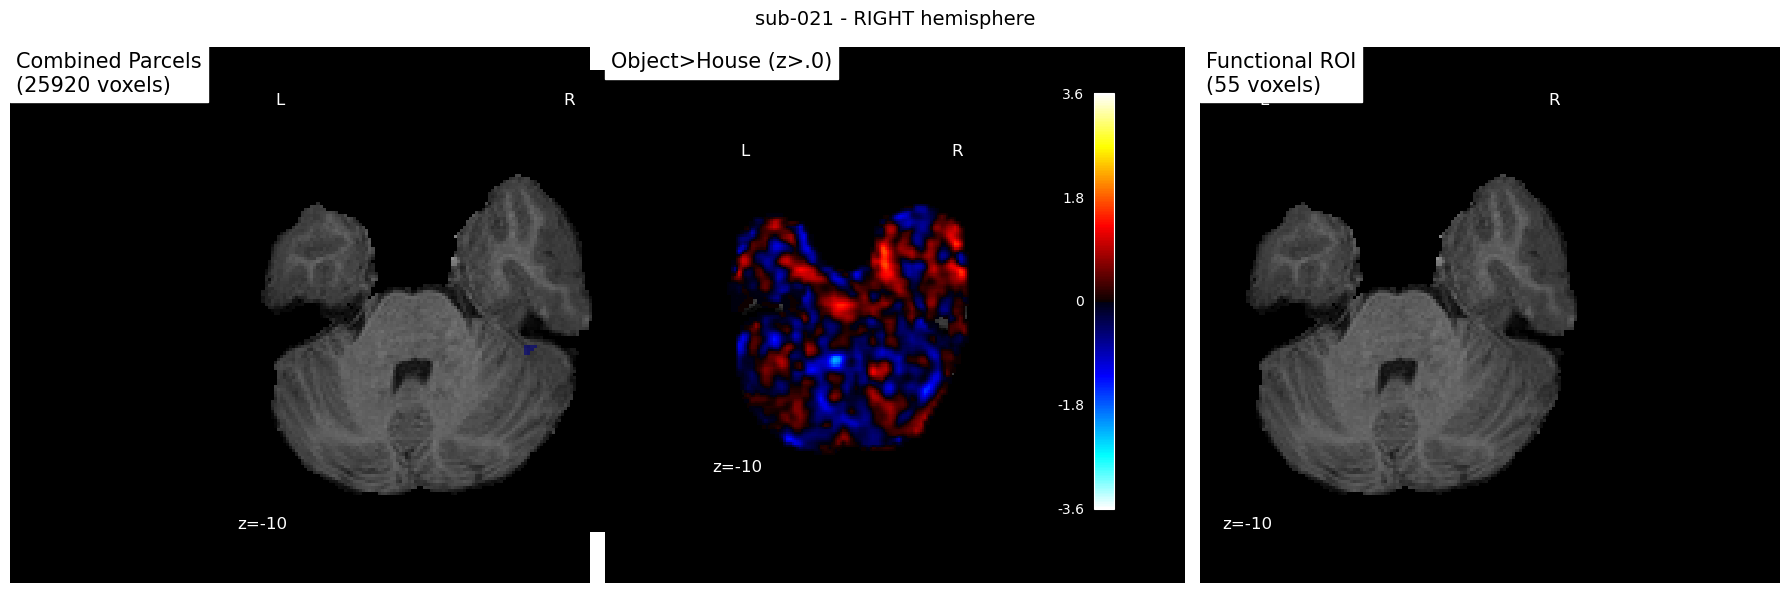

In [19]:
# Visualize combined mask and cope 14 activation
from nilearn import plotting

for subject_id in SUBJECTS.keys():
    intact_hemi = SUBJECTS[subject_id]['intact_hemisphere']
    
    # Build combined mask
    ventral_parcels = ['FFA', 'OFA', 'PFS', 'LO', 'PPA', 'OPA']
    combined_mask = np.zeros((176, 256, 256))
    
    for parcel in ventral_parcels:
        parcel_img = load_parcel(subject_id, parcel, intact_hemi)
        if parcel_img:
            combined_mask += parcel_img.get_fdata()
    
    combined_mask = (combined_mask > 0).astype(np.float32)
    
    # Load cope 14
    zstats = []
    for run in range(1, 4):
        zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                     f'run-0{run}' / '1stLevel.feat' / 'reg_standard' / 'stats' / 'zstat14.nii.gz'
        zstats.append(nib.load(zstat_file).get_fdata())
    mean_zstat = np.mean(zstats, axis=0)
    
    # Get functional ROI
    roi_mask, _, n_vox = find_functional_roi(subject_id, 14, intact_hemi, threshold=2.0)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    anat = nib.load(anat_file)
    
    # 1. Combined parcel mask
    mask_img = nib.Nifti1Image(combined_mask, anat.affine)
    plotting.plot_roi(mask_img, bg_img=anat, axes=axes[0], 
                     title=f'Combined Parcels\n({int(combined_mask.sum())} voxels)',
                     display_mode='z', cut_coords=[-10], alpha=0.6)
    
    # 2. Cope 14 activation (unmasked)
    zstat_img = nib.Nifti1Image(mean_zstat.astype(np.float32), anat.affine)
    plotting.plot_stat_map(zstat_img, bg_img=anat, axes=axes[1],
                          threshold=0, title='Object>House (z>.0)',
                          display_mode='z', cut_coords=[-10])
    
    # 3. Functional ROI (masked activation)
    if roi_mask is not None:
        roi_img = nib.Nifti1Image(roi_mask.astype(np.float32), anat.affine)
        plotting.plot_roi(roi_img, bg_img=anat, axes=axes[2],
                         title=f'Functional ROI\n({n_vox} voxels)',
                         display_mode='z', cut_coords=[-10], alpha=0.6, cmap='Reds')
    
    fig.suptitle(f'{subject_id} - {intact_hemi.upper()} hemisphere', fontsize=14)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f'{subject_id}_cope14_roi_debug.png', dpi=150)
    plt.show()

In [1]:
# Check what HighLevel copes exist and list them
import os

subject_id = 'sub-004'
session = '01'
highlevel_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'

print("HighLevel copes found:")
copes_found = []
for i in range(1, 20):
    cope_dir = highlevel_dir / f'cope{i}.feat'
    if cope_dir.exists():
        copes_found.append(i)
        print(f"  cope{i}.feat")

print(f"\nTotal copes: {len(copes_found)}")
print(f"Cope numbers: {copes_found}")

# Try to find design.fsf or design.con to see contrast definitions
fsf_file = highlevel_dir / 'design.fsf'
if fsf_file.exists():
    print("\nFound design.fsf - checking contrasts...")
    with open(fsf_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'set fmri(conname_real' in line or 'set fmri(conname_orig' in line:
                print(line.strip())

NameError: name 'BASE_DIR' is not defined